**Report of Project 3: "Implementation and evaluation of Otsu Thresholding"**

*presented by Elizaveta Chernova, Veronika Schuler, Laura Wächter, Hannah Winter*

Otsu Thresholding is 

In [2]:
from nuclei_segmentation import otsu

In [4]:
from skimage.io import imread
from skimage.io import imshow
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
from nuclei_segmentation.pathlist import pathlist
from nuclei_segmentation.otsu import otsu_faster
from nuclei_segmentation.otsu import otsu_twolevel
from nuclei_segmentation.evaluation import dice_score_faster
from nuclei_segmentation.evaluation import iou
from nuclei_segmentation.otsu import clipping

In [3]:
image = imread(r'Data\NIH3T3\im\dna-27.png')

FileNotFoundError: No such file: '/Users/veronikaschuler/PycharmProjects/2021-topic-04-team-03/Data\NIH3T3\im\dna-27.png'

In [4]:
%%timeit
otsu.otsu(image)

NameError: name 'otsu' is not defined

In [6]:
%%timeit
threshold_otsu(image)

NameError: name 'image' is not defined

In [ ]:
%%timeit
otsu.otsuna(image)

In [ ]:
%%timeit
otsu.otsu_faster(image)

This is our pipeline assembly 

In [7]:
    N2DH_GOWT1_gt_list = pathlist("./Data/N2DH-GOWT1/gt", ".tif")
    print(N2DH_GOWT1_gt_list)
    N2DH_GOWT1_img_list = pathlist("./Data/N2DH-GOWT1/img", ".tif")
    print(N2DH_GOWT1_img_list)

    N2DL_HeLa_gt_list = pathlist("./Data/N2DL-HeLa/gt", ".tif")
    print(N2DL_HeLa_gt_list)
    N2DL_HeLa_img_list = pathlist("./Data/N2DL-HeLa/img", ".tif")
    print(N2DL_HeLa_img_list)

    NIH3T3_gt_list = pathlist("./Data/NIH3T3/gt", ".png")
    print(NIH3T3_gt_list)
    NIH3T3_img_list = pathlist("./Data/NIH3T3/im", ".png")
    print(NIH3T3_img_list)

NameError: name 'pathlist' is not defined

In [8]:
%pylab
%matplotlib inline


for image in N2DH_GOWT1_gt_list:
    N2DH_GOWT1 = imread(image)
    figure()
    imshow()

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/veronikaschuler/anaconda3/envs/bioinfo/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['imshow', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


NameError: name 'N2DH_GOWT1_gt_list' is not defined

In [3]:
from skimage.io import imread_collection

#1st dataset N2DH_GOWT1
img_N2DH_GOWT1_dir = [r'''Data/N2DH-GOWT1/img/*.tif''']
img_N2DH_GOWT1 = imread_collection(img_N2DH_GOWT1_dir)
#an example of accessing a single image from a list 
print(img_N2DH_GOWT1[0])
plt.imshow(img_N2DH_GOWT1[0], "gray")
plt.show()

gt_N2DH_GOWT1_dir = [r'''Data/N2DH-GOWT1/gt/*.tif''']
gt_N2DH_GOWT1 = imread_collection(gt_N2DH_GOWT1_dir)



# 2nd dataset N2DL_HeLa
img_N2DL_HeLa_dir = [r'''Data/N2DL-HeLa/img/*.tif''']
img_N2DL_HeLa = imread_collection(img_N2DL_HeLa_dir)

gt_N2DL_HeLa_dir = [r'''Data/N2DL-HeLa/gt/*.tif''']
gt_N2DL_HeLa = imread_collection(gt_N2DL_HeLa_dir)



# 3rd dataset NIH3T3
img_NIH3T3_dir = [r'''Data/NIH3T3/img/*.png''']
img_NIH3T3 = imread_collection(img_NIH3T3_dir)

gt_NIH3T3_dir = [r'''Data/NIH3T3/gt/*.png''']
gt_NIH3T3 = imread_collection(gt_NIH3T3_dir)




TypeError: unexpected keyword argument: img_num

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


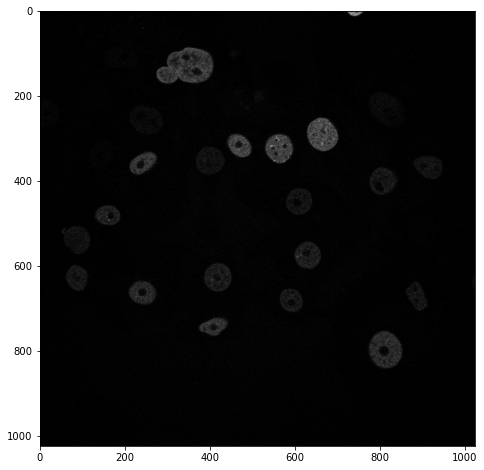

In [42]:
%pylab
%matplotlib inline

img = imread("./Data/N2DH-GOWT1/img/t01.tif")
figure(figsize=(15,8))
imshow(img, "gray")

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


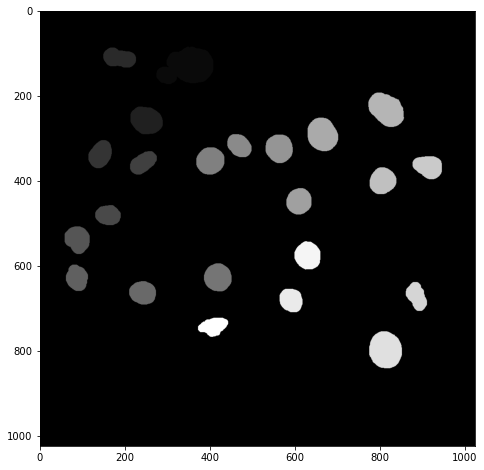

In [27]:
%pylab
%matplotlib inline

gt_N2DH-GOWT1 = imread("./Data/N2DH-GOWT1/gt/man_seg01.tif")
figure(figsize=(15,8))
imshow(gt, "gray")

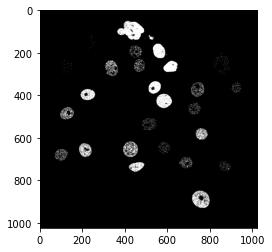

In [46]:
#using otsu thresholding on a single image
otsu_threshold = otsu_faster(img)
otsu_threshold
#using otsu thresholding on several images 
for image in N2DH_GOWT1:
    otsu_threshold, goodness = otsu_faster(image)
    clipped = clipping(image, otsu_threshold)
    plt.imshow(clipped, "gray")
    
    

In [ ]:
#using otsu thresholding on a single image
otsu_threshold = otsu_faster(img)
otsu_threshold
#using otsu thresholding on several images 
for image in N2DH_GOWT1:
    otsu_threshold, goodness = otsu_faster(image)
    clipped = clipping(image, otsu_threshold)
    plt.imshow(clipped, "gray")

In [50]:
# dice score
dice_score_faster(clipped, gt_N2DH-GOWT1)

0.13328294787114722

In [51]:
# IoU
IoU(clipped,gt_N2DH-GOWT1)


0.07139965198215116